# AIF_sprint7-recruit-kaggle

## 時系列データとは

今回のデータの特徴量の中に日付データが存在する。

時間関係（年月日時分秒）の項目が存在するデータを**時系列データ**を呼ぶ。

時系列データを取り扱う際には下記の２点に注意する必要がある。

- 予測するときに　未来のデータから過去のデータを予測しない
- 目的を明確にする。　（通年 or 特定の期間（休日、季節、天気、月など）のどちらで精度を出せばよいのか

特に検証方法に注意が必要で、通常の交差検証ではなく**時系列交差検証**を行う必要がある。

### 問題を理解する

今回の問題はリクルートの運営する２システム（airレジ、ホットペッパーグルメ）の予約情報、店舗情報、来客者数のデータから
未来の来客者数を予測することです。

#### 概要

繁盛している地方レストランの経営は第一印象ほど魅力的なものではない しばしば経営を傷つけうる予期せぬトラブルが起こります。

一つの共通の苦境はレストランは食材の確保や人のスケジューリングを効率的に 行うために毎日何人お客が来るのかを知る必要があることです。

この予測は予期せぬ多くの要素（天気や競合レストラン）があるため簡単ではない。

新しいレストランはなおさらである。

リクルートはたくさんのサイトやシステムを持っているからそれらの予測ができるような データを持っている。

このコンペでは予約や訪問データを使って将来の日付のレストランの来客者数を予測して

この予測データによってレストランはより効率的に運営できるようになって 楽しい食事体験を生み出すことにフォーカスできるようになる。

#### 問題
教師あり学習の回帰問題

#### 評価方法
RMSLE(対数誤差平均二乗和)

### 提出内容
８２１店舗(air_id)３９日分　（２０１７年４月２３日〜２０１７年５月３１日）の来客者予測人数

#### データセットの内容

- air_reserve.csv   : airレジの予約情報
    - air_store_id レストランのairシステムのID
    - visit_datetime 予約された訪問時間
    - reserve_datetime 予約した時間
    - reserve_visitors 予約人数
- hpg_reserve.csv :ホットペッパーグルメの予約情報
    - hpg_store_id レストランのホットペッパーグルメでのID
    - visit_datetime 予約された訪問時間
    - reserve_datetime 予約した時間
    - reserve_visitors 予約人数
- air_store_info.csv : 店情報(air)
    - air_store_id レストランのairシステムのID
    - air_genre_name　ジャンル
    - air_area_name　住所
    - latitude　緯度
    - longitude 経度
- hpg_store_info.csv : 店情報（ホットペッパーグルメ）
    - hpg_store_id レストランのホットペッパーグルメのID
    - hpg_genre_name ジャンル
    - hpg_area_name 住所
    - latitude 緯度
    - longitude 経度
- store_id_relation.csv : ホットペッパーグルメとairのIDの関係性
    - hpg_store_id レストランのホットペッパーグルメのID
    - air_store_id レストランのairシステムのID
- air_visit_data.csv
    - air_store_id : airシステムのID
    - visit_date : 日付
    - visitors : その日の訪問者数
- sample_submission.csv
    - id : airシステムのIDと日付
    - visitors :　予測すべき訪問者数
- date_info.csv : カレンダーの日付と曜日と祝日かどうか
    - calendar_date : カレンダーの日付
    - day_of_week : 曜日
    - holiday_flg : 祝日かどうか

### データ・セットの用意

#### データ量の調整
学習に関して、いきなり大量のデータを使用すると時間がかかりすぎてしまう場合があります。

そこで、学習を最初に行う場合は、データを減らす（サンプリング）して学習を行いましょう。

反省：時間に追われ、データセットの削減をやっていなかった、
データ量が少なければコード実行やデバッグ、検証がもっとイテレートできた。

### -> 5/25 復習期間があったのでデータセットを削減して実施しています。データ量を絞り、それぞれの課題、手法の理解を優先しているためEDAを除いて全データでの実行は行っておりません。 

## TRY: プロトタイプコードを書くときはミニマムなデータセットを使ってコーディングを行う。

### EDA

In [26]:
# 必要なモジュールを読み込み
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
# データの読み込み
# date_infoのみcalendar_dateをvisit_dateに変更　=>結合のため
# air_visit_data が訓練データ
# sample_submissionがテストデータ　ここまではあっていた。
data = {
    'tra':
    pd.read_csv('../input/air_visit_data.csv.zip'),
    'as':
    pd.read_csv('../input/air_store_info.csv.zip'),
    'hs':
    pd.read_csv('../input/hpg_store_info.csv.zip'),
    'ar':
    pd.read_csv('../input/air_reserve.csv.zip'),
    'hr':
    pd.read_csv('../input/hpg_reserve.csv.zip'),
    'id':
    pd.read_csv('../input/store_id_relation.csv.zip'),
    'tes':
    pd.read_csv('../input/sample_submission.csv.zip'),
    'hol':
    pd.read_csv('../input/date_info.csv.zip').rename(columns={
        'calendar_date': 'visit_date'
    })
}

In [28]:
data['tra'].head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [29]:
data['tes'].head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


In [30]:
data['as'].head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [32]:
data['hs'].head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


In [33]:
data['ar'].head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [34]:
data['hr'].head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [35]:
data['id'].head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [36]:
data['hol'].head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [37]:
for name,d in data.items():
    print(name, d.isnull().sum().sum())

tra 0
as 0
hs 0
ar 0
hr 0
id 0
tes 0
hol 0


すべて欠損値がないデータであることが分かります。

In [38]:
data['tra'].describe()

,visitors
count,252108.000000
mean,20.973761
std,16.757007
min,1.000000
25%,9.000000
50%,17.000000
75%,29.000000
max,877.000000


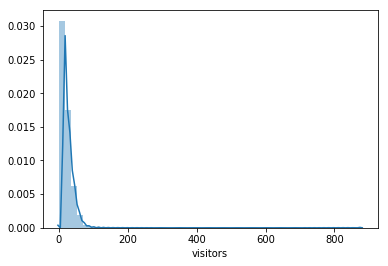

In [39]:
sns.distplot(data['tra']['visitors']);

describe()と来客人数の分布を見ると

- 平均２０人
- 休日はデータにないので最低１人
- 1~100人に収まっている。

が見てとれます。

### 前処理の実装と説明

今回は前処理として下記の三点を実施した。

- 時系列データの対応
    - 今回時系列データが含まれているのでread_csvしただけでは文字列として認識されている。これをdatetime型に変換する。
- カテゴリデータの数値データへの変換
- csv同士のデータの連結
    - 今回はCSVファイルにデータがまたがっているので特徴量として使用するためにデータをmergeなどで連結する。
    
 前処理やモデル学習は
[このカーネル](https://www.kaggle.com/festa78/simple-lightgbm-lb-0-493)を参考にしました。

In [40]:
import gc
del data['tra'], data['tes']
gc.collect()

5658

In [41]:
# データの絞込み 検証時はコメントアウトを外す
data['tra'] = pd.read_csv('../input/air_visit_data.csv.zip', nrows=1000)
data['tes'] = pd.read_csv('../input/sample_submission.csv.zip', nrows=1000)

In [42]:
# ホットペッパーグルメの予約情報にリレーション情報を内部結合
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

# airとhpgの予約情報
for df in ['ar', 'hr']:
    # datetime型に変換
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    # 予約日と訪問日の差をreserve_datetime_diffに格納
    data[df]['reserve_datetime_diff'] = data[df].apply(
        lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    # 並び替えて何をしているか分からない@@@@
    data[df] = data[df].groupby(
        ['air_store_id', 'visit_datetime'], as_index=False)[[
            'reserve_datetime_diff', 'reserve_visitors'
        ]].sum().rename(columns={
            'visit_datetime': 'visit_date'
        })
    
# 訓練データに特徴量として、年月日、曜日、年、月を追加
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

# テストデータのidをair_store_idとvisit_dateに分割
data['tes']['visit_date'] = data['tes']['id'].map(
    lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(
    lambda x: '_'.join(x.split('_')[:2]))

# テストデータに特徴量として、年月日、曜日、年、月を追加
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

# 予測しなければならない店のair_idを保持
unique_stores = data['tes']['air_store_id'].unique()

# 店ごとに７日分の行を確保
stores = pd.concat(
    [
        pd.DataFrame({
            'air_store_id': unique_stores,
            'dow': [i] * len(unique_stores)
        }) for i in range(7)
    ],
    axis=0,
    ignore_index=True).reset_index(drop=True)

# sure it can be compressed... 圧縮できるはず...
# その曜日の来客者数の
# 最少値　
# 平均
# 中央値
# 最大値
# をsotresに追加
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].min().rename(columns={
        'visitors': 'min_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].mean().rename(columns={
        'visitors': 'mean_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].median().rename(columns={
        'visitors': 'median_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].max().rename(columns={
        'visitors': 'max_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].count().rename(columns={
        'visitors': 'count_observations'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

# 店のジャンルや位置情報を離散値に変換して追加
stores = pd.merge(stores, data['as'], how='left', on=['air_store_id'])
lbl = preprocessing.LabelEncoder()
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

# 祝日や曜日情報（離散値に変換）を訓練データ、テストデータに結合する
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date

train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date'])
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date'])

# 今まで作成したstoresを訓練、テストデータに結合
# その曜日の来客者数の最少値、平均、中央値、最大値
# 店のジャンルや位置情報
train = pd.merge(data['tra'], stores, how='left', on=['air_store_id', 'dow'])
test = pd.merge(data['tes'], stores, how='left', on=['air_store_id', 'dow'])

# webからの予約情報を結合
for df in ['ar', 'hr']:
    train = pd.merge(
        train, data[df], how='left', on=['air_store_id', 'visit_date'])
    test = pd.merge(
        test, data[df], how='left', on=['air_store_id', 'visit_date'])

# id, air_store_id, visit_date, visitors以外の項目をcolに格納
col = [
    c for c in train
    if c not in ['id', 'air_store_id', 'visit_date', 'visitors']
]
# 欠損値を-1埋めする
train = train.fillna(-1)
test = test.fillna(-1)

#### 評価関数を用意する

In [43]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer

# 評価関数を定義
def root_mean_squared_log_error(truth, pred):
    return np.sqrt(mean_squared_log_error(truth, pred))

rmsle = make_scorer(root_mean_squared_log_error, greater_is_better=False)

### モデルの作成

今回はlightGBMモデルを使用してモデル学習、予測を行った。
コードは下記の通り。

In [44]:
# float64からfloat32型への変換
for c, dtype in zip(train.columns, train.dtypes):
    if dtype == np.float64:
        train[c] = train[c].astype(np.float32)

for c, dtype in zip(test.columns, test.dtypes):
    if dtype == np.float64:
        test[c] = test[c].astype(np.float32)

# 説明変数を作成、　特徴量として店のIDと訪問日、来客者数（目的変数）を省く
X_train = train.drop(['air_store_id', 'visit_date', 'visitors'], axis=1)
# 目的変数を格納
y_train = train['visitors'].values

# テストデータの説明変数を作成
X_test = test.drop(['id', 'air_store_id', 'visit_date', 'visitors'], axis=1)

# parameter tuning of lightgbm
# start from default setting
# 他のカーネルのパラメーターを見たい
gbm0 = lgb.LGBMRegressor(
    objective='regression', # 回帰
    num_leaves=60, 
    learning_rate=0.01,
    n_estimators=10000)

gbm0.fit(X_train, y_train, eval_metric=rmsle)
y_predict = gbm0.predict(X_test)
# 0以下の値は0に変換する
y_predict[y_predict<0] = 0

test['visitors'] = y_predict
test[['id', 'visitors']].to_csv(
    'lggm_submission.csv', index=False, float_format='%.3f')  # LB0.493

### 評価関数について、なぜ数ある評価関数からこの評価関数を選択しているか考察せよ

今回予測した来客数と実際の来客数の差を誤差関数とする。

数ある誤差関数の中でlog(x+1)の値を取った理由としては下の図のように
予測値2０人と実際の来客者10人のときの誤差と
予測値5０人と実際の来客者60人のときの誤差は前者の方が大きい。

店側の損失としてもたくさん来たときはお断りすればよいだけなので損失は少ないが、
人数が少ないときは材料費もたくさん買うときよりも高くつくため、予測が外れたときの損失は大きい。

今回のコンペではこのような店側の損失を考慮し、対数を取った誤差を採用していると考えられる。

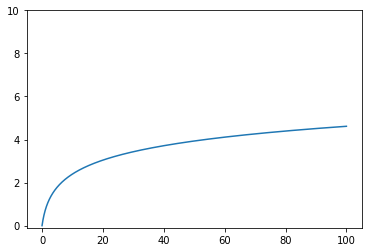

In [45]:
x = np.arange(.0,100,0.01)
y = np.log(x + 1)

plt.ylim(-0.1, 10)

plt.plot(x,y)
plt.show()

### 時系列検証

今回行った時系列交差検証を手順は下記の通り。

1. trainデータを日付順でソートする
1. TimeSeriesSplitで分割されたインデックスから訓練データ、テストデータを作成
1. 評価関数を使って性能評価

訓練データとテストデータの間隔を空けることで本番と同じ日付間隔で検証する必要がある。
今回は簡易な検証として間隔を空ける処理は実装しない。

In [53]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(max_train_size=400,n_splits=3)

# 訓練データを日付順にソートする
train_sort = train.sort_values('visit_date')

for train_index, test_index in tscv.split(train_sort):
    # 検証用の訓練データとテストデータを用意
    valid_train, valid_test = train_sort.iloc[train_index, : ], train_sort.iloc[test_index, : ]
    
    # 訓練データ
    train_x, train_y  = valid_train.drop(['air_store_id', 'visit_date', 'visitors'], axis=1), valid_train['visitors'].values
    # テストデータ
    test_x, test_y = valid_test.drop(['air_store_id', 'visit_date', 'visitors'], axis=1), valid_test['visitors'].values

    gbm0 = lgb.LGBMRegressor(
        objective='regression', # 回帰
        num_leaves=60,
        min_data_in_leaf=100,
        learning_rate=0.01,
        n_estimators=10000)

    gbm0.fit(train_x, train_y, eval_metric=rmsle)
    predict_y = gbm0.predict(test_x)
    # 0以下の値は0に変換する
    predict_y[predict_y<0] = 0
    # 最小値の確認
    # print(np.min(predict_y))
    print(np.sqrt(mean_squared_log_error(test_y, predict_y) ))

0.9799770258675747
1.0315497806948872
1.0873398035993909


### Bayesian Hyperparameter Optimization

ハイパーパラメータチューニングの方法として、グリッドサーチではなく他の方法もあります。

今回は、ベイズを使用したBayesian Hyperparameter Optimizationを利用して、一部のモデルのハイパーパラメータチューニングを行う。

[githubのサンプルページ](https://github.com/fmfn/BayesianOptimization/blob/master/examples/xgboost_example.py)を参考に検証を行った。


In [51]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

from bayes_opt import BayesianOptimization
from tqdm import tqdm


# 評価関数を定義
def root_mean_squared_log_error(truth, pred):
    return np.sqrt(mean_squared_log_error(truth, pred))

# 検証用データを用意
rmsle = make_scorer(root_mean_squared_log_error, greater_is_better=False)

X_train, X_test, y_train, y_test = train_test_split(
                                                    train.drop(['air_store_id', 'visit_date', 'visitors'], axis=1),
                                                    train['visitors'].values,
                                                    test_size=0.2,
                                                    random_state=0)

lgtrain = lgb.Dataset(X_train, label=y_train)
lgvalid = lgb.Dataset(X_test, label=y_test)

num_rounds = 1000
random_state = 2016
num_iter = 15
init_points = 5
params = {
    'eval_metric': rmsle,
    'seed': random_state
}



# 最大化する関数を定義する
def lgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample):

    lgb_reg = lgb.LGBMRegressor(max_depth=int(max_depth),
                                min_child_weight = min_child_weight,
                                colsample_bytree = colsample_bytree,
                                subsample=subsample
                               )

    lgb_reg.fit(X_train, y_train, eval_metric=rmsle)

    y_predict = lgb_reg.predict(X_test)
    y_predict[y_predict<0] = 0
    eval_val = root_mean_squared_log_error(y_test, y_predict) 
    print(eval_val)
    return -eval_val


# ベイジアンモデルに最大化すべき関数と取り得る範囲を指定
lgbBO = BayesianOptimization(lgb_evaluate, {'min_child_weight': (1, 20),
                                            'colsample_bytree': (0.1, 1),
                                            'max_depth': (5, 15),
                                            'subsample': (0.5, 1)
                                            })

lgbBO.maximize(init_points=init_points, n_iter=num_iter)

Initialization
---------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |   max_depth |   min_child_weight |   subsample | 
0.9243124212303314
    1 | 00m00s |   -0.92431 |             0.3366 |     14.1963 |             1.1439 |      0.5359 | 
0.9259835985467978
    2 | 00m00s |   -0.92598 |             0.6174 |      8.1456 |            19.9375 |      0.7732 | 
0.9184541046862904
    3 | 00m00s |   -0.91845 |             0.7060 |     13.8103 |             4.6905 |      0.6371 | 
0.9156407742632701
    4 | 00m00s |   -0.91564 |             0.7124 |      7.3569 |             4.0567 |      0.8877 | 
0.9239903210025472
    5 | 00m00s |   -0.92399 |             0.1407 |      5.9193 |            16.5787 |      0.5303 | 
Bayesian Optimization
---------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |   max_depth

/Users/kzfm/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.56072258e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


0.914681821843933
   13 | 00m20s |   -0.91468 |             1.0000 |     15.0000 |             1.0000 |      1.0000 | 
0.9249981103356106
   14 | 00m22s |   -0.92500 |             0.1000 |     15.0000 |            20.0000 |      0.5000 | 


/Users/kzfm/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.32543996e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


0.906110650531906
   15 | 00m22s |   -0.90611 |             1.0000 |      5.0000 |            17.5152 |      0.5000 | 
0.9171720592324525
   16 | 00m23s |   -0.91717 |             0.9499 |      7.7432 |             6.0465 |      0.5279 | 
0.9149585943184347
   17 | 00m16s |   -0.91496 |             0.9989 |     15.0000 |            14.0357 |      0.9440 | 
0.914720358537101
   18 | 00m19s |   -0.91472 |             0.9375 |     10.6030 |             1.1377 |      0.9730 | 
0.9224052073232609
   19 | 00m19s |   -0.92241 |             1.0000 |     14.8441 |            17.1392 |      0.5000 | 
0.9224052073232609
   20 | 00m23s |   -0.92241 |             0.9767 |     15.0000 |             9.9139 |      0.5000 | 


### アンサンブル学習

今回は下記２モデルで予測を行いシンプルなスタッキングを行いました。

スタッキングの方法は下記を参考にしました。

> [スタッキングの方法](http://segafreder.hatenablog.com/entry/2016/05/24/235822)

- [シンプルなlightGBMモデルのカーネル](https://www.kaggle.com/festa78/simple-lightgbm-lb-0-493)

スタッキングでの検証方法は[sprint8のノートブック](https://github.com/kz23szk/diveintocode-term1/blob/master/sprint8/sprint8-kaggle-mercari.ipynb)で説明しています。

今回は検証がうまくいったとして２モデルで予測結果を出力し、それらを説明変数として最終的な予測を行った。

In [65]:
set(X_test.columns) - set(X_train.columns)

{'id'}

In [67]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge


X_train = train.drop(['air_store_id', 'visit_date', 'visitors'], axis=1)
y_train = train['visitors'].values
X_test = test.drop(['air_store_id', 'visit_date', 'visitors','id'], axis=1)

######################
# STEP1 : 2モデルでの学習　スタッキング用の説明変数（訓練データの予測値）を作成
######################

score_ridge_list = []
score_lgb_list = []

predict = np.zeros((y_train.shape[0], 2))

kf = KFold(n_splits=3)
for train_index, test_index in kf.split(X_train):
    cv_X_train, cv_X_test = X_train.iloc[train_index, : ], X_train.iloc[test_index, : ]
    cv_y_train, cv_y_test = y_train[train_index], y_train[test_index]

    # Ridge回帰
    model_ridge = Ridge(alpha=20)
    model_ridge.fit(cv_X_train, cv_y_train)
    y_predict_ridge = model_ridge.predict(cv_X_test)
    y_predict_ridge[y_predict_ridge<0] = 0

    # lightGBMモデルの作成
    # ベイジアン最適化で得られたパラメータを使う
    lgb_reg = lgb.LGBMRegressor(max_depth=10,
                                    min_child_weight = 4.5842,
                                    colsample_bytree = 1,
                                    subsample=1
                                   )

    lgb_reg.fit(X_train, y_train, eval_metric=rmsle)

    y_predict_lgb = lgb_reg.predict(cv_X_test)
    y_predict_lgb[y_predict_lgb<0] = 0
    
    score_ridge = root_mean_squared_log_error(cv_y_test, y_predict_ridge)
    score_lgb = root_mean_squared_log_error(cv_y_test, y_predict_lgb)
    
    score_ridge_list.append(score_ridge)
    score_lgb_list.append(score_lgb)
    
#     print("Ridge回帰：{}".format(score_ridge))
#     print("lightGBM：{}".format(score_lgb))
    
    predict[test_index, 0] = y_predict_ridge
    predict[test_index, 1]= y_predict_lgb  
    
######################
# スタッキング用のX_testを作成
######################

# Ridge回帰
model_ridge = Ridge(alpha=20)
model_ridge.fit(X_train, y_train)
y_predict_ridge = model_ridge.predict(X_test)

# LightGBMモデルで学習
model_lgb = lgb.LGBMRegressor(max_depth=10,
                                    min_child_weight = 4.5842,
                                    colsample_bytree = 1,
                                    subsample=1
                                   )
model_lgb.fit(X_train, y_train)
y_predict_lgb = model_lgb.predict(X_test)

# テストデータの予測値を説明変数とする
y_predict_two_modle = np.array([y_predict_ridge, y_predict_lgb]).T

######################
# 予測値を使って学習し、最終的な予測値を出力する
######################
model_lgb = lgb.LGBMRegressor(max_depth=10,
                                    min_child_weight = 4.5842,
                                    colsample_bytree = 1,
                                    subsample=1
                                   )
model_lgb.fit(predict, y_train)
y_predict_stacking = model_lgb.predict(y_predict_two_modle)

test['visitors'] = y_predict_stacking
test[['id', 'visitors']].to_csv(
    'ensemble_submission.csv', index=False, float_format='%.3f')  # LB0.493

Ridge回帰：0.6588450766106914
lightGBM：0.5231717994453062
Ridge回帰：1.5966278371103968
lightGBM：1.3334981545972089
Ridge回帰：0.7980143919438323
lightGBM：0.6942583044525831


### （おまけ）アンサンブル学習について

Q: まったく同じ訓練データを使って５個の異なるモデルを訓練し、それらがすべて９５％の適合率を達成したとき、
それらのモデルを組み合わせたらもっと良い結果が得られる可能性があるか？そうでないとすればそれはなぜか？

A: 良い結果が生まれることが多い。モデルが大きく異なる場合（たとえばSVM分類器、決定木分類器、ロジスティック回帰分類器など）に
高い性能を示すことが多い。経験的にNN系とGBM系はスタッキングの相性がよい。

異なる訓練インスタンスで訓練するとさらに性能は上がる（バギングやペースティングといったアンサンブルのポイント）が、
そうでなくても、モデルが大きく異なれば、性能は上がる。

>[scikit-learnとTensorFlowによる実践機械学習](https://www.amazon.co.jp/scikit-learn%E3%81%A8TensorFlow%E3%81%AB%E3%82%88%E3%82%8B%E5%AE%9F%E8%B7%B5%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92-Aur%C3%A9lien-G%C3%A9ron/dp/4873118344/ref=pd_sim_14_2?_encoding=UTF8&psc=1&refRID=VXMR0HPCZ8BT55D001R6)